# Book Recommendation System

A recommendation system seeks to predict the rating or preference a user would give to an item given his old item ratings or preferences. Recommendation systems are used by pretty much every major company in order to enhance the quality of their services.

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

warnings.filterwarnings('ignore')
%matplotlib inline

## Loading in data

In [33]:
dataset = pd.read_csv('../Data/final_rating_not_spare.csv', usecols=['customer_id', 'product_id', 'stars'])

In [34]:
customer_index = np.unique(dataset['customer_id'])
customer_index = np.sort(customer_index)
dataset['id_customer'] = dataset['customer_id'].apply(lambda x: np.where(customer_index==int(x))[0][0])

In [35]:
dataset.drop('customer_id', axis=1, inplace=True)
dataset.rename(columns={'id_customer': 'customer_id'}, inplace=True)

In [36]:
product_index = np.unique(dataset['product_id'])
product_index = np.sort(product_index)
dataset['id_product'] = dataset['product_id'].apply(lambda x: np.where(product_index==int(x))[0][0])

In [37]:
dataset.drop('product_id', axis=1, inplace=True)
dataset.rename(columns={'id_product': 'product_id'}, inplace=True)

In [38]:
dataset.head()

stars  customer_id  product_id
0      5          571        5019
1      4          990        5019
2      5          607        1610
3      5          958        1610
4      5          767        1610

In [39]:
dataset.shape

(20849, 3)

In [40]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

In [41]:
train.head()

stars  customer_id  product_id
20208      2          956        2036
17795      5          566        3302
4985       5         1304        2631
2487       4          222         315
16795      5          257        3584

In [42]:
test.head()

stars  customer_id  product_id
20188      4          329        3230
19586      5          838        1734
9674       5          483        2094
4579       5         1295        4673
6669       5          812        3591

In [43]:
n_users = len(dataset.customer_id.unique())
n_users

1382

In [44]:
n_books = len(dataset.product_id.unique())
n_books

5289

## Creating dot product model
Most recommendation systems are build using a simple dot product as shown below but newer ones are now implementing a neural network instead of the simple dot product.

In [45]:
# creating book embedding path
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# performing dot product and creating model
prod = Dot(name="Dot-Product", axes=1)([book_vec, user_vec])
model = Model([user_input, book_input], prod)
model.compile('adam', 'mean_squared_error')

Epoch 1/50
16679/16679 [==============================] - 1s 75us/step - loss: 20.5845
Epoch 2/50
16679/16679 [==============================] - 1s 72us/step - loss: 19.4341
Epoch 3/50
16679/16679 [==============================] - 1s 67us/step - loss: 18.1386
Epoch 4/50
16679/16679 [==============================] - 1s 88us/step - loss: 16.7484
Epoch 5/50
16679/16679 [==============================] - 1s 75us/step - loss: 15.3109
Epoch 6/50
16679/16679 [==============================] - 1s 69us/step - loss: 13.8714
Epoch 7/50
16679/16679 [==============================] - 1s 62us/step - loss: 12.4663
Epoch 8/50
16679/16679 [==============================] - 1s 59us/step - loss: 11.1262
Epoch 9/50
16679/16679 [==============================] - 1s 64us/step - loss: 9.8715
Epoch 10/50
16679/16679 [==============================] - 1s 62us/step - loss: 8.7153
Epoch 11/50
16679/16679 [==============================] - 1s 64us/step - loss: 7.6634
Epoch 12/50
16679/16679 [===================

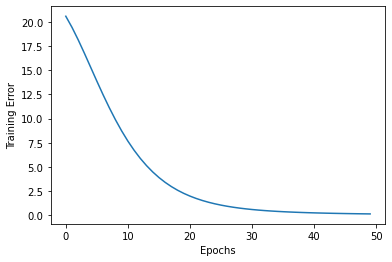

In [52]:
from keras.models import load_model

if os.path.exists('regression_model.h5'):
    model = load_model('regression_model.h5')
else:
    history = model.fit([train.customer_id, train.product_id], train.stars, epochs=50, verbose=1)
    # model.save('regression_model.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [53]:
model.evaluate([test.customer_id, test.product_id], test.stars)

4170/4170 [==============================] - 0s 32us/step


7.049689017554267

In [54]:
predictions = model.predict([test.customer_id.head(10), test.product_id.head(10)])

[print(predictions[i], test.stars.iloc[i]) for i in range(0,10)]

[5.143941] 4
[3.2399294] 5
[0.09688075] 5
[4.7377706] 5
[4.7378154] 5
[2.9844112] 5
[2.4144075] 5
[4.9952374] 5
[5.4207945] 5
[5.1782465] 5


[None, None, None, None, None, None, None, None, None, None]

## Creating Neural Network
Neural Networks proved there effectivness for almost every machine learning problem as of now and they also perform exceptionally well for recommendation systems.

In [55]:
# creating book embedding path
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([book_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

# Create model and compile it
model2 = Model([user_input, book_input], out)
model2.compile('adam', 'mean_squared_error')

In [58]:
from keras.models import load_model

# if os.path.exists('regression_model2.h5'):
#     model2 = load_model('regression_model2.h5')
# else:
history = model2.fit([train.customer_id, train.product_id], train.stars, epochs=20, verbose=1)
# model2.save('regression_model2.h5')


Epoch 1/20
16679/16679 [==============================] - 2s 98us/step - loss: 2.2757
Epoch 2/20
16679/16679 [==============================] - 1s 79us/step - loss: 0.2887
Epoch 3/20
16679/16679 [==============================] - 1s 85us/step - loss: 0.2439
Epoch 4/20
16679/16679 [==============================] - 1s 78us/step - loss: 0.2044
Epoch 5/20
16679/16679 [==============================] - 1s 78us/step - loss: 0.1787
Epoch 6/20
16679/16679 [==============================] - 1s 81us/step - loss: 0.1605
Epoch 7/20
16679/16679 [==============================] - 1s 84us/step - loss: 0.1493
Epoch 8/20
16679/16679 [==============================] - 1s 79us/step - loss: 0.1380
Epoch 9/20
16679/16679 [==============================] - 1s 79us/step - loss: 0.1286
Epoch 10/20
16679/16679 [==============================] - 1s 80us/step - loss: 0.1190
Epoch 11/20
16679/16679 [==============================] - 1s 77us/step - loss: 0.1084
Epoch 12/20
16679/16679 [===========================

KeyError: 'accuracy'

Text(0, 0.5, 'Training Error')

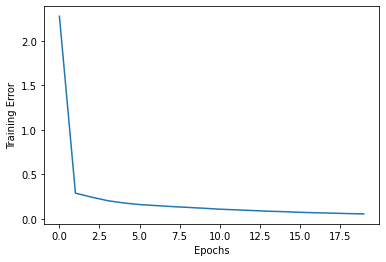

In [60]:
plt.plot(history.history['loss'])
# plt.plot(history.history['acc'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [62]:
model2.evaluate([test.customer_id, test.product_id], test.stars)

4170/4170 [==============================] - 0s 41us/step


0.5873290100257745

In [67]:
predictions = model2.predict([test.customer_id.tail(20), test.product_id.tail(20)])

[print(predictions[i], test.stars.iloc[i]) for i in range(0,20)]

[5.165611] 4
[4.9797435] 5
[4.9698734] 5
[4.9954605] 5
[4.1169677] 5
[5.0501494] 5
[5.005706] 5
[5.0135846] 5
[4.6286716] 5
[4.09948] 5
[5.034922] 5
[4.8439126] 5
[4.9466147] 5
[5.04659] 5
[5.0505767] 5
[4.9875216] 5
[4.9677677] 5
[4.2978697] 5
[5.009051] 5
[3.2302828] 5


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## Visualizing Embeddings
Embeddings are weights that are learned to represent some specific variable like books and user in our case and therefore we can not only use them to get good results on our problem but also to extract inside about our data.

In [18]:
# Extract embeddings
book_em = model.get_layer('Book-Embedding')
book_em_weights = book_em.get_weights()[0]

In [19]:
book_em_weights[:5]

array([[-0.00610029,  0.0156836 ,  0.03038192,  0.0425691 , -0.02896588],
       [-1.5306774 ,  0.5250458 ,  2.366743  ,  1.3422308 , -1.0649071 ],
       [-1.2195548 ,  0.41940942,  2.508028  ,  1.8110565 , -1.1244056 ],
       [-0.5183603 ,  1.0415146 ,  2.5360963 ,  0.71309656, -1.3203545 ],
       [-1.3798604 , -0.9113507 ,  1.9190255 ,  1.5787991 ,  0.7250671 ]],
      dtype=float32)

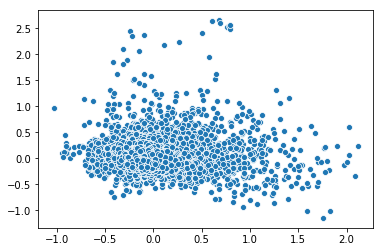

In [20]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [21]:
book_em_weights = book_em_weights / np.linalg.norm(book_em_weights, axis = 1).reshape((-1, 1))
book_em_weights[0][:10]
np.sum(np.square(book_em_weights[0]))

1.0

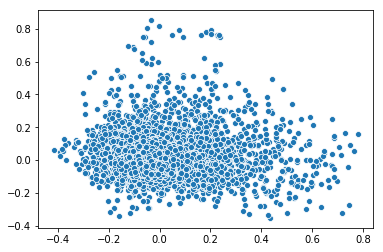

In [22]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [23]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(book_em_weights)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10001 samples in 0.007s...
[t-SNE] Computed neighbors for 10001 samples in 0.840s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10001
[t-SNE] Computed conditional probabilities for sample 2000 / 10001
[t-SNE] Computed conditional probabilities for sample 3000 / 10001
[t-SNE] Computed conditional probabilities for sample 4000 / 10001
[t-SNE] Computed conditional probabilities for sample 5000 / 10001
[t-SNE] Computed conditional probabilities for sample 6000 / 10001
[t-SNE] Computed conditional probabilities for sample 7000 / 10001
[t-SNE] Computed conditional probabilities for sample 8000 / 10001
[t-SNE] Computed conditional probabilities for sample 9000 / 10001
[t-SNE] Computed conditional probabilities for sample 10000 / 10001
[t-SNE] Computed conditional probabilities for sample 10001 / 10001
[t-SNE] Mean sigma: 0.018763
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.958824
[t-SNE] KL

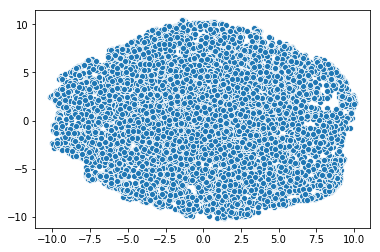

In [24]:
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

## Making Recommendations

In [25]:
# Creating dataset for making recommendations for the first user
book_data = np.array(list(set(dataset.book_id)))
book_data[:5]

array([1, 2, 3, 4, 5])

In [26]:
user = np.array([1 for i in range(len(book_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [27]:
predictions = model.predict([user, book_data])

predictions = np.array([a[0] for a in predictions])

recommended_book_ids = (-predictions).argsort()[:5]

recommended_book_ids

array([4867, 8945, 7253, 5398, 7843], dtype=int64)

In [28]:
# print predicted scores
predictions[recommended_book_ids]

array([4.9399395, 4.914757 , 4.883313 , 4.8180933, 4.7592154],
      dtype=float32)

In [29]:
books = pd.read_csv('books.csv')
books.head()

id  book_id  best_book_id  work_id  books_count       isbn        isbn13  \
0   1  2767052       2767052  2792775          272  439023483  9.780439e+12   
1   2        3             3  4640799          491  439554934  9.780440e+12   
2   3    41865         41865  3212258          226  316015849  9.780316e+12   
3   4     2657          2657  3275794          487   61120081  9.780061e+12   
4   5     4671          4671   245494         1356  743273567  9.780743e+12   

                       authors  original_publication_year  \
0              Suzanne Collins                     2008.0   
1  J.K. Rowling, Mary GrandPré                     1997.0   
2              Stephenie Meyer                     2005.0   
3                   Harper Lee                     1960.0   
4          F. Scott Fitzgerald                     1925.0   

                             original_title  \
0                          The Hunger Games   
1  Harry Potter and the Philosopher's Stone   
2                                  Twilight   
3                     To Kill a Mockingbird   
4                          The Great Gatsby   

                         ...                         ratings_count  \
0                        ...                               4780653   
1                        ...                               4602479   
2                        ...                               3866839   
3                        ...                               3198671   
4                        ...                               2683664   

  work_ratings_count  work_text_reviews_count  ratings_1  ratings_2  \
0            4942365                   155254      66715     127936   
1            4800065                    75867      75504     101676   
2            3916824                    95009     456191     436802   
3            3340896                    72586      60427     117415   
4            2773745                    51992      86236     197621   

   ratings_3  ratings_4  ratings_5  \
0     560092    1481305    2706317   
1     455024    1156318    3011543   
2     793319     875073    1355439   
3     446835    1001952    1714267   
4     606158     936012     947718   

                                           image_url  \
0  https://images.gr-assets.com/books/1447303603m...   
1  https://images.gr-assets.com/books/1474154022m...   
2  https://images.gr-assets.com/books/1361039443m...   
3  https://images.gr-assets.com/books/1361975680m...   
4  https://images.gr-assets.com/books/1490528560m...   

                                     small_image_url  
0  https://images.gr-assets.com/books/1447303603s...  
1  https://images.gr-assets.com/books/1474154022s...  
2  https://images.gr-assets.com/books/1361039443s...  
3  https://images.gr-assets.com/books/1361975680s...  
4  https://images.gr-assets.com/books/1490528560s...  

[5 rows x 23 columns]

In [30]:
books[books['id'].isin(recommended_book_ids)]

id   book_id  best_book_id   work_id  books_count        isbn  \
4866  4867   5215879       5215879   5283119           31   425227723   
5397  5398    167010        167010   1138857           17  140120077X   
7252  7253     22875         22875    409548           34   345418476   
7842  7843  17182421      17182421  21762912           49   778315339   
8944  8945     32529         32529   3214115           40   752848267   

            isbn13                                            authors  \
4866  9.780425e+12                                Laurell K. Hamilton   
5397  9.781401e+12  Bill Willingham, Mark Buckingham, Steve Leialo...   
7252  9.780345e+12                               Stephen R. Donaldson   
7842  9.780778e+12                                         Jason Mott   
8944  9.780753e+12                                       Lisa Gardner   

      original_publication_year                 original_title  \
4866                     2009.0                     Skin Trade   
5397                     2003.0  Fables, Volume 2: Animal Farm   
7252                     1982.0                   The One Tree   
7842                     2013.0                   The Returned   
8944                     2001.0              The Next Accident   

                            ...                         ratings_count  \
4866                        ...                                 29261   
5397                        ...                                 23951   
7252                        ...                                 13812   
7842                        ...                                 11449   
8944                        ...                                 11261   

     work_ratings_count  work_text_reviews_count  ratings_1  ratings_2  \
4866              31383                     1081        952       2377   
5397              24620                     1113        133        645   
7252              15334                      136        247        786   
7842              13269                     2452        581       2122   
8944              13328                      513         49        231   

      ratings_3  ratings_4  ratings_5  \
4866       6995       9455      11604   
5397       4400      10514       8928   
7252       3444       5739       5118   
7842       5100       3798       1668   
8944       2323       5612       5113   

                                              image_url  \
4866  https://images.gr-assets.com/books/1310494564m...   
5397  https://images.gr-assets.com/books/1364233122m...   
7252  https://s.gr-assets.com/assets/nophoto/book/11...   
7842  https://images.gr-assets.com/books/1372089735m...   
8944  https://images.gr-assets.com/books/1348816896m...   

                                        small_image_url  
4866  https://images.gr-assets.com/books/1310494564s...  
5397  https://images.gr-assets.com/books/1364233122s...  
7252  https://s.gr-assets.com/assets/nophoto/book/50...  
7842  https://images.gr-assets.com/books/1372089735s...  
8944  https://images.gr-assets.com/books/1348816896s...  

[5 rows x 23 columns]